<a href="https://colab.research.google.com/github/katiegaertner/CatvsDog/blob/main/CatsAndDogs2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt

#Bring in the Data

In [2]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [3]:
! kaggle competitions download -c 'dogs-vs-cats-redux-kernels-edition'

  0% 0.00/111k [00:00<?, ?B/s]
100% 111k/111k [00:00<00:00, 30.1MB/s]
 96% 261M/271M [00:01<00:00, 168MB/s]
100% 271M/271M [00:01<00:00, 165MB/s]
 98% 534M/544M [00:03<00:00, 115MB/s]
100% 544M/544M [00:03<00:00, 144MB/s]


In [4]:
! mkdir kaggletrain
! unzip train.zip -d kaggletrain

Streaming output truncated to the last 5000 lines.
  inflating: kaggletrain/train/dog.5499.jpg  
  inflating: kaggletrain/train/dog.55.jpg  
  inflating: kaggletrain/train/dog.550.jpg  
  inflating: kaggletrain/train/dog.5500.jpg  
  inflating: kaggletrain/train/dog.5501.jpg  
  inflating: kaggletrain/train/dog.5502.jpg  
  inflating: kaggletrain/train/dog.5503.jpg  
  inflating: kaggletrain/train/dog.5504.jpg  
  inflating: kaggletrain/train/dog.5505.jpg  
  inflating: kaggletrain/train/dog.5506.jpg  
  inflating: kaggletrain/train/dog.5507.jpg  
  inflating: kaggletrain/train/dog.5508.jpg  
  inflating: kaggletrain/train/dog.5509.jpg  
  inflating: kaggletrain/train/dog.551.jpg  
  inflating: kaggletrain/train/dog.5510.jpg  
  inflating: kaggletrain/train/dog.5511.jpg  
  inflating: kaggletrain/train/dog.5512.jpg  
  inflating: kaggletrain/train/dog.5513.jpg  
  inflating: kaggletrain/train/dog.5514.jpg  
  inflating: kaggletrain/train/dog.5515.jpg  
  inflating: kaggletrain/train/do

In [5]:
#use colab directory kaggletrain/train
%cd kaggletrain/train

#create new labeled folders
if os.path.isdir('train/dog') is False:
  os.makedirs('train/dog')
  os.makedirs('train/cat')
  os.makedirs('valid/dog')
  os.makedirs('valid/cat')
  os.makedirs('test/dog')
  os.makedirs('test/cat')

/content/kaggletrain/train


In [6]:
#create smaller train, test, validation sets to reduce computational cost
for i in random.sample(glob.glob('cat*'), 9500):
        shutil.move(i, 'train/cat')      
for i in random.sample(glob.glob('dog*'), 9500):
        shutil.move(i, 'train/dog')
for i in random.sample(glob.glob('cat*'), 2500):
        shutil.move(i, 'valid/cat')        
for i in random.sample(glob.glob('dog*'), 2500):
        shutil.move(i, 'valid/dog')
for i in random.sample(glob.glob('cat*'), 500):
        shutil.move(i, 'test/cat')      
for i in random.sample(glob.glob('dog*'), 500):
        shutil.move(i, 'test/dog')

In [7]:
#create variables for paths
train_path = '/content/kaggletrain/train/train'
valid_path = '/content/kaggletrain/train/valid'
test_path = '/content/kaggletrain/train/test'

#create batches of data from directories
#using VGG16 preprocessor
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=train_path, target_size=(224,224), classes=['cat', 'dog'], batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=valid_path, target_size=(224,224), classes=['cat', 'dog'], batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=test_path, target_size=(224,224), classes=['cat', 'dog'], batch_size=10, shuffle=False)

Found 19000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

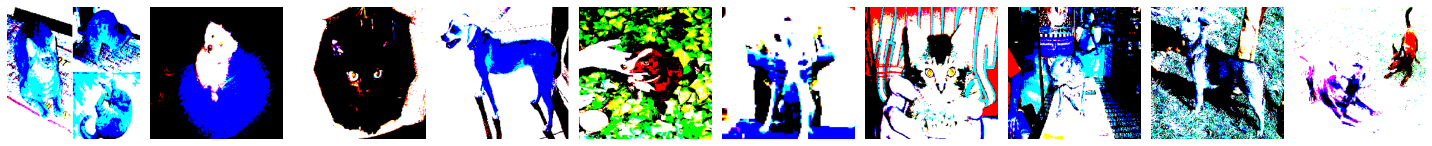

[[1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [8]:
#confirm import worked by visualizing the data

imgs, labels = next(train_batches)

#plotting function from TensorFlow documentation
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

plotImages(imgs)
print(labels)

#Simple CNN Model

In [9]:
#Build the Model

model = Sequential([
    #convolutional layer with 32 filters size of 3x3 with zero padding
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding = 'same', input_shape=(224,224,3)),
    MaxPool2D(pool_size=(2, 2), strides=2),
    #convolutional layer with 64 filter size of 3x3 with zero padding
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Flatten(),
    Dense(units=2, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 200704)            0         
                                                                 
 dense (Dense)               (None, 2)                 4

In [10]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

### Train Simple Model

In [11]:
model.fit(x=train_batches, 
          steps_per_epoch=len(train_batches), 
          validation_data=valid_batches, 
          validation_steps=len(valid_batches), 
          epochs=5, 
          verbose=2)

Epoch 1/5
1900/1900 - 91s - loss: 1.7926 - accuracy: 0.6834 - val_loss: 0.5659 - val_accuracy: 0.7206 - 91s/epoch - 48ms/step
Epoch 2/5
1900/1900 - 81s - loss: 0.3472 - accuracy: 0.8492 - val_loss: 0.7076 - val_accuracy: 0.7076 - 81s/epoch - 43ms/step
Epoch 3/5
1900/1900 - 81s - loss: 0.1716 - accuracy: 0.9363 - val_loss: 0.7555 - val_accuracy: 0.7198 - 81s/epoch - 43ms/step
Epoch 4/5
1900/1900 - 82s - loss: 0.1081 - accuracy: 0.9616 - val_loss: 0.9116 - val_accuracy: 0.7288 - 82s/epoch - 43ms/step
Epoch 5/5
1900/1900 - 82s - loss: 0.0799 - accuracy: 0.9727 - val_loss: 1.1205 - val_accuracy: 0.7268 - 82s/epoch - 43ms/step


In [12]:
#prepare test data
test_imgs, test_labels = next(test_batches)

#predictions
predictions = model.predict(x=test_batches, steps=len(test_batches), verbose=0)
y_pred = np.argmax(predictions, axis=-1)

###Evaluate Simple Model

In [13]:
# confusion matrix (code from scikit-learn)
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

test_batches.class_indices

{'cat': 0, 'dog': 1}

Confusion matrix, without normalization
[[321 179]
 [105 395]]


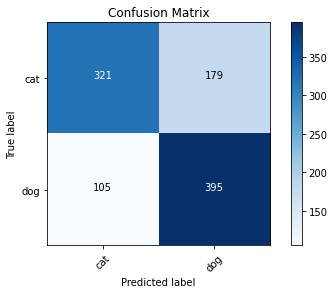

In [14]:
cm_plot_labels = ['cat','dog']

cm = confusion_matrix(y_true=test_batches.classes, y_pred=y_pred)

plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [15]:
from sklearn.metrics import roc_curve, auc

test_labels = test_batches.classes
#DELETE# y_pred = np.argmax(y_pred_keras, axis=-1)

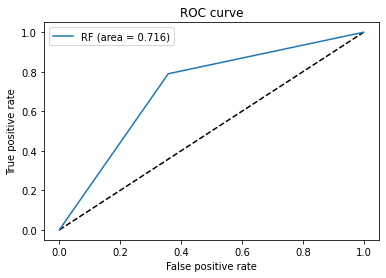

In [16]:
fpr, tpr, threshold = roc_curve(test_labels, y_pred)
auc_rf = auc(fpr, tpr)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [17]:
print('The AUC for the Simple CNN Model is:', auc_rf)

The AUC for the Simple CNN Model is: 0.7160000000000001


#Tuned Models

In [32]:
#bring in Keras Tuner
!pip install -q -U keras-tuner
import keras_tuner as kt
#define stop early
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

## Model 1

In [19]:
#Define the Model

def model_builder(hp):
  model = keras.Sequential()
  #Tune filters in the first layer
  hp_filters = hp.Int('filters', min_value=32, max_value=160, step=32)
  model.add(keras.layers.Conv2D(filters=hp_filters,
                                kernel_size=(3,3),
                                activation='relu',
                                padding='same',
                                input_shape=(224,224,3)))
  model.add(MaxPool2D(pool_size=(2, 2), strides=2))
  model.add(Flatten())
  model.add(Dense(units=2, activation='softmax'))

  model.compile(loss='categorical_crossentropy', optimizer=Adam(hp.Choice('learning_rate', values=[1e-1, 1e-3])), metrics=['accuracy'])

  return model

### Tune Model 1

In [20]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='/content',
                     project_name='model1')

In [ ]:
tuner.search(train_batches, epochs=50, validation_data=valid_batches, callbacks=[stop_early])

Trial 7 Complete [00h 03m 59s]
val_accuracy: 0.6043999791145325

Best val_accuracy So Far: 0.640999972820282
Total elapsed time: 00h 24m 25s

Search: Running Trial #8

Hyperparameter    |Value             |Best Value So Far 
filters           |96                |32                
learning_rate     |0.1               |0.001             
tuner/epochs      |2                 |2                 
tuner/initial_e...|0                 |0                 
tuner/bracket     |2                 |2                 
tuner/round       |0                 |0                 

Epoch 1/2
1899/1900 [============================>.] - ETA: 0s - loss: 2400234.2500 - accuracy: 0.5482

In [ ]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
Hyperparameter search is complete.
Optimal number of filters for the Conv2S Layer: {best_hps.get('filters')}.
Optimal learning rate: {best_hps.get('learning_rate')}.
""")

In [ ]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
best_model1 = tuner.get_best_models()[0]
best_model1.summary()

### Train Model 1

In [ ]:
best_model1.fit(x=train_batches,
                steps_per_epoch=len(train_batches),
                validation_data=valid_batches,
                validation_steps=len(valid_batches),
                epochs=5,
                verbose=2
                )

### Evaluate Model 1

In [ ]:
#predictions
predictionsm1 = best_model1.predict(x=test_batches, steps=len(test_batches), verbose=0)
y_pred = np.argmax(predictionsm1, axis=-1)

In [ ]:
#Confusion Matrix

cm = confusion_matrix(y_true=test_batches.classes, y_pred=y_pred)
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [ ]:
#ROC Curve and AUC

fpr, tpr, threshold = roc_curve(test_labels, y_pred)
auc_rf = auc(fpr, tpr)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [ ]:
print('The AUC for the Simple Model 1 is:', auc_rf)

## Model 2

In [ ]:
def model_builder(hp):
  model = keras.Sequential()
  #Tune filters in the first layer
  model.add(keras.layers.Conv2D(filters=128,
                                kernel_size=(3,3),
                                activation='relu',
                                padding='same',
                                input_shape=(224,224,3)))
  model.add(MaxPool2D(pool_size=(2, 2), strides=2))
  hp_filters = hp.Int('filters', min_value=128, max_value=512, step=32)
  model.add(keras.layers.Conv2D(filters=hp_filters,
                                kernel_size=(3,3),
                                activation='relu',
                                padding='same'))
  model.add(Flatten())
  model.add(Dense(units=2, activation='softmax'))

  model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

  return model

### Tune Model 2

In [ ]:
model2_tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='/content',
                     project_name='model2')

In [33]:
model2_tuner.search(train_batches, epochs=50, validation_data=valid_batches, callbacks=[stop_early])

Trial 20 Complete [00h 08m 27s]
val_accuracy: 0.5

Best val_accuracy So Far: 0.5842000246047974
Total elapsed time: 02h 06m 06s
INFO:tensorflow:Oracle triggered exit


In [34]:
best_hps=model2_tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
Hyperparameter search is complete.
Optimal number of filters for the Conv2S Second Layer: {best_hps.get('filters')}.
""")


Hyperparameter search is complete.
Optimal number of filters for the Conv2S Second Layer: 512.



In [35]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
best_model2 = tuner.get_best_models()[0]
best_model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 401408)            0         
                                                                 
 dense (Dense)               (None, 2)                 802818    
                                                                 
Total params: 803,714
Trainable params: 803,714
Non-trainable params: 0
_________________________________________________________________


### Train Model 2

In [36]:
best_model2.fit(x=train_batches,
                steps_per_epoch=len(train_batches),
                validation_data=valid_batches,
                validation_steps=len(valid_batches),
                epochs=5,
                verbose=2
                )

Epoch 1/5
1900/1900 - 87s - loss: 54.8718 - accuracy: 0.6867 - val_loss: 132.8413 - val_accuracy: 0.5754 - 87s/epoch - 46ms/step
Epoch 2/5
1900/1900 - 83s - loss: 41.5898 - accuracy: 0.7313 - val_loss: 137.4704 - val_accuracy: 0.5522 - 83s/epoch - 44ms/step
Epoch 3/5
1900/1900 - 82s - loss: 47.7475 - accuracy: 0.7588 - val_loss: 61.0688 - val_accuracy: 0.6352 - 82s/epoch - 43ms/step
Epoch 4/5
1900/1900 - 82s - loss: 36.1570 - accuracy: 0.7936 - val_loss: 100.6109 - val_accuracy: 0.6352 - 82s/epoch - 43ms/step
Epoch 5/5
1900/1900 - 82s - loss: 41.5827 - accuracy: 0.8115 - val_loss: 78.5110 - val_accuracy: 0.6422 - 82s/epoch - 43ms/step


###Evaluate Model 2

In [37]:
#predictions
predictionsm2 = best_model2.predict(x=test_batches, steps=len(test_batches), verbose=0)
y_pred = np.argmax(predictionsm2, axis=-1)

Confusion matrix, without normalization
[[370 130]
 [200 300]]


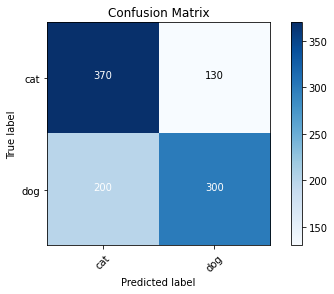

In [38]:
#Confusion Matrix
cm = confusion_matrix(y_true=test_batches.classes, y_pred=y_pred)
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

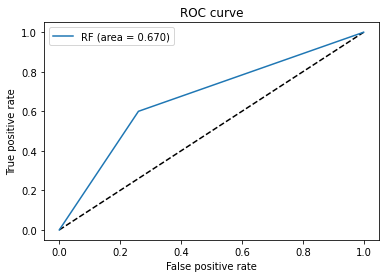

In [39]:
#ROC Curve
fpr, tpr, threshold = roc_curve(test_labels, y_pred)
auc_rf = auc(fpr, tpr)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [40]:
#AUC
print('The AUC for the Model 2 is:', auc_rf)

The AUC for the Model 2 is: 0.6699999999999999


## Model 3

### Fine tune the model using VGG16

In [41]:
vgg16_model = tf.keras.applications.vgg16.VGG16()

553476096/553467096 [==============================] - 8s 0us/step


In [42]:
model3 = Sequential()
for layer in vgg16_model.layers[:-1]:
  model3.add(layer)

#do not retrain since cats and dogs are in the VGG16 model
for layer in model3.layers:
  layer.trainable = False

#add final layer with two possible outcomes
model3.add(Dense(units=2, activation='softmax'))

In [43]:
model3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)      

In [44]:
model3.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

### Train Model 3

In [45]:
model3.fit(x=train_batches, 
           steps_per_epoch=len(train_batches),
           validation_data=valid_batches,
           validation_steps=len(valid_batches),
           epochs=5,
           verbose=2
           )

Epoch 1/5
1900/1900 - 114s - loss: 0.1196 - accuracy: 0.9761 - val_loss: 0.1724 - val_accuracy: 0.9788 - 114s/epoch - 60ms/step
Epoch 2/5
1900/1900 - 122s - loss: 0.0864 - accuracy: 0.9859 - val_loss: 0.1647 - val_accuracy: 0.9788 - 122s/epoch - 64ms/step
Epoch 3/5
1900/1900 - 107s - loss: 0.0644 - accuracy: 0.9873 - val_loss: 0.1784 - val_accuracy: 0.9802 - 107s/epoch - 56ms/step
Epoch 4/5
1900/1900 - 109s - loss: 0.0509 - accuracy: 0.9903 - val_loss: 0.2260 - val_accuracy: 0.9782 - 109s/epoch - 57ms/step
Epoch 5/5
1900/1900 - 114s - loss: 0.0446 - accuracy: 0.9914 - val_loss: 0.2213 - val_accuracy: 0.9820 - 114s/epoch - 60ms/step


### Evaluate Model 3

In [46]:
#predictions
predictionsm3 = model3.predict(x=test_batches, steps=len(test_batches), verbose=0)
y_pred = np.argmax(predictionsm3, axis=-1)

Confusion matrix, without normalization
[[493   7]
 [ 18 482]]


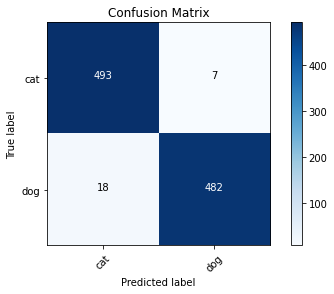

In [47]:
#Confusion Matrix
cm = confusion_matrix(y_true=test_batches.classes, y_pred=y_pred)
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

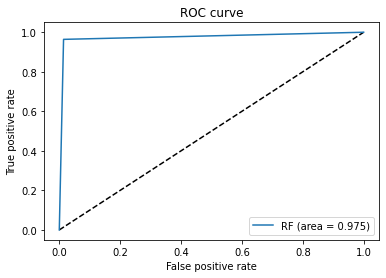

In [48]:
#ROC Curve
fpr, tpr, threshold = roc_curve(test_labels, y_pred)
auc_rf = auc(fpr, tpr)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [49]:
#AUC
print('The AUC for the Model 3 is:', auc_rf)

The AUC for the Model 3 is: 0.975


#Kaggle Submission

In [50]:
from google.colab import drive
drive.mount('/drive')

Mounted at /drive


In [52]:
! mkdir /content/kaggletest
! unzip /content/test.zip -d /content/kaggletest

Streaming output truncated to the last 5000 lines.
  inflating: /content/kaggletest/test/5499.jpg  
  inflating: /content/kaggletest/test/55.jpg  
  inflating: /content/kaggletest/test/550.jpg  
  inflating: /content/kaggletest/test/5500.jpg  
  inflating: /content/kaggletest/test/5501.jpg  
  inflating: /content/kaggletest/test/5502.jpg  
  inflating: /content/kaggletest/test/5503.jpg  
  inflating: /content/kaggletest/test/5504.jpg  
  inflating: /content/kaggletest/test/5505.jpg  
  inflating: /content/kaggletest/test/5506.jpg  
  inflating: /content/kaggletest/test/5507.jpg  
  inflating: /content/kaggletest/test/5508.jpg  
  inflating: /content/kaggletest/test/5509.jpg  
  inflating: /content/kaggletest/test/551.jpg  
  inflating: /content/kaggletest/test/5510.jpg  
  inflating: /content/kaggletest/test/5511.jpg  
  inflating: /content/kaggletest/test/5512.jpg  
  inflating: /content/kaggletest/test/5513.jpg  
  inflating: /content/kaggletest/test/5514.jpg  
  inflating: /content/

In [53]:
path = '/content/kaggletest'

#create batches of data using VGG16 preprocessor

test_gen = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input)
kaggle_batches = test_gen.flow_from_directory(
    directory=path,
    batch_size=10,
    class_mode=None,
    target_size=(224, 224),
    shuffle=False
    )

Found 12500 images belonging to 1 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

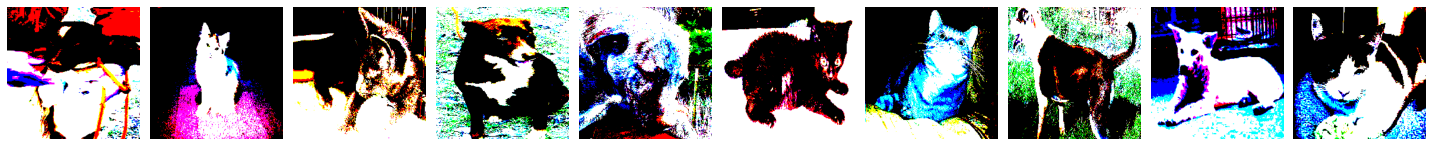

In [54]:
#confirm import worked by visualizing the data

imgs = next(kaggle_batches)

#plotting function from TensorFlow documentation
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

plotImages(imgs)

##Simple CNN Model

In [55]:
predictions_simple = model.predict(x=kaggle_batches, steps=len(kaggle_batches), verbose=0)

In [56]:
import pandas as pd

#output and format best model predictions for Kaggle
predict_simple = pd.DataFrame(predictions_simple)
predict_simple.index.rename('id', inplace=True)
predict_simple.index += 1
predict_simple.rename(columns={1: 'label'}, inplace=True)
predict_simple.drop(labels=0, axis=1, inplace=True)

In [57]:
predict_simple.to_csv('/drive/My Drive/Gaertner_simpleCatsVsDogs_prediction.csv')

##Model 1

In [58]:
predictions_model1 = best_model1.predict(x=kaggle_batches, steps=len(kaggle_batches), verbose=0)

In [59]:
#output and format best model predictions for Kaggle
predict_m1 = pd.DataFrame(predictions_model1)
predict_m1.index.rename('id', inplace=True)
predict_m1.index += 1
predict_m1.rename(columns={1: 'label'}, inplace=True)
predict_m1.drop(labels=0, axis=1, inplace=True)

In [60]:
predict_m1.to_csv('/drive/My Drive/Gaertner_model1_CatsVsDogs_prediction.csv')

##Model 2

In [61]:
predictions_model2 = best_model2.predict(x=kaggle_batches, steps=len(kaggle_batches), verbose=0)

In [62]:
#output and format best model predictions for Kaggle
predict_m2 = pd.DataFrame(predictions_model2)
predict_m2.index.rename('id', inplace=True)
predict_m2.index += 1
predict_m2.rename(columns={1: 'label'}, inplace=True)
predict_m2.drop(labels=0, axis=1, inplace=True)

In [68]:
predict_m2.to_csv('/drive/My Drive/Gaertner_model2_CatsVsDogs_prediction.csv')

##Model 3

In [64]:
predictions_m3 = model3.predict(x=kaggle_batches, steps=len(kaggle_batches), verbose=0)

In [76]:
#output and format best model predictions for Kaggle
predict_m3 = pd.DataFrame(predictions_m3)
predict_m3.index.rename('id', inplace=True)
predict_m3.index += 1
predict_m3.rename(columns={1: 'label'}, inplace=True)
predict_m3.drop(labels=0, axis=1, inplace=True)

In [77]:
predict_m3.to_csv('/drive/My Drive/Gaertner_modelfinal_CatsVsDogs_prediction.csv')

In [73]:
predict_m3.head()

,label
id,
1,1.000000e+00
2,1.921850e-26
3,2.403945e-27
4,1.000000e+00
5,1.000000e+00


In [74]:
predict_m2.head()

,label
id,
1,1.0
2,1.0
3,0.0
4,1.0
5,1.0
